In [1]:
#Importing the relevant Libraries for EDA & MODEL TRAINING


import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)# The maximum width in characters of a column in the repr of a pandas data structure
from time import time
import re
import string
import os
import emoji
from pprint import pprint #Pretty print of data in case of json
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import joblib
import gensim
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import sklearn.pipeline
import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)

 # 1.  Read The data and select the feature for further Analysis

In [7]:
Data = pd.read_csv('/Users/sagarkant/Documents/Code/DataStore/Sentiment_Twitter_Data.csv')
Data = Data.reindex(np.random.permutation(Data.index))
Data = Data[['text', 'sentiment']]

# 2.  Explore the Data 


1. See the balance of classes in the dataset.

   Negative class is highly present as compared to other two classes

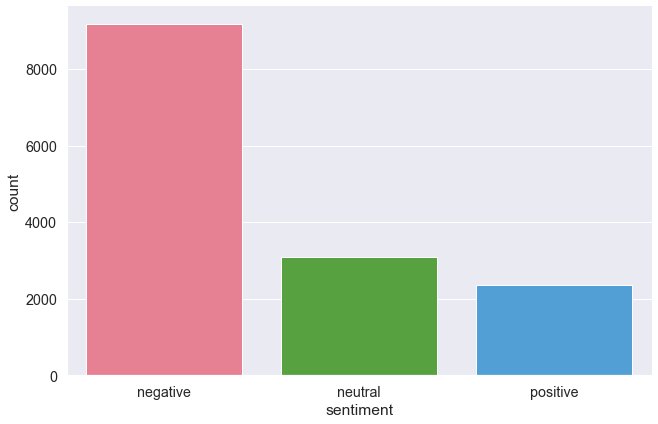

In [8]:
sns.factorplot(x="sentiment", data=Data, kind="count", size=6, aspect=1.5, palette="husl")
plt.show();

# 2.1 See the below vertex
    Counting words and its Descriptive stats
    Counting @ and its Descriptive stats
    Counting hashtag and its Descriptive stats
    Counting capital letter and its Descriptive stats
    Counting Exclamation and Question marks and its Descriptive stats
    Counting https links and its Descriptive stats
    Counting Emoji and its Descriptive stats
    


Below is the Estimator which is designed to process the above requirements.

In [9]:
class Sentiment_Text_Count(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        Data = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return Data
tc = Sentiment_Text_Count()
data_eda = tc.fit_transform(Data.text)
data_eda['sentiment'] = Data.sentiment

Below Function to Print the Describe function and Its Plot.

In [10]:
def data_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1) #returns ndarray withing specified interval equal spacing
    g = sns.FacetGrid(df, col='sentiment', size=5, hue='sentiment', palette="husl")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

#For Word counts 

  1.Negative sentiments has maximum words used.
  
  2.Some comments are of 1 word.
  
  3.Negative comments are more than other two.
    
    

Descriptive stats for count_words
---------------------------------
            count       mean       std  min   25%   50%   75%   max
sentiment                                                          
negative   9178.0  19.360754  6.141609  1.0  16.0  21.0  24.0  35.0
neutral    3099.0  14.273637  7.165208  1.0  9.0   14.0  20.0  33.0
positive   2363.0  13.538299  7.270138  1.0  8.0   14.0  20.0  32.0


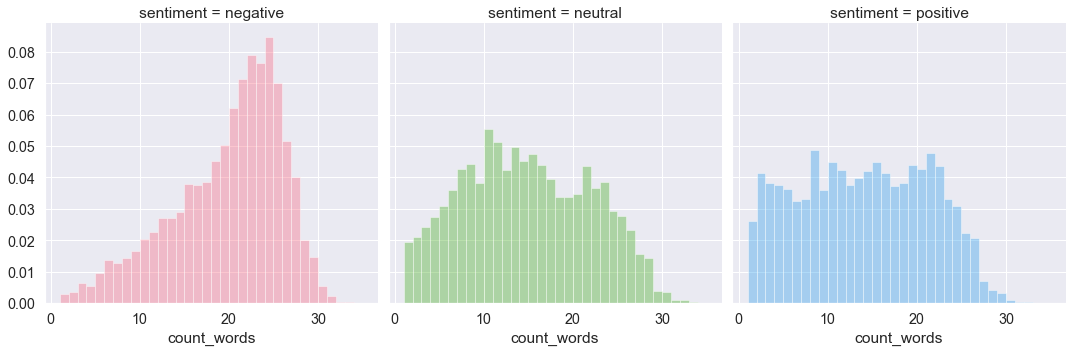

In [11]:
data_dist(data_eda,'count_words')

Descriptive stats for count_mentions
------------------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
negative   9178.0  0.120179  0.378748  0.0  0.0  0.0  0.0  5.0
neutral    3099.0  0.184576  0.501265  0.0  0.0  0.0  0.0  4.0
positive   2363.0  0.159120  0.462923  0.0  0.0  0.0  0.0  5.0


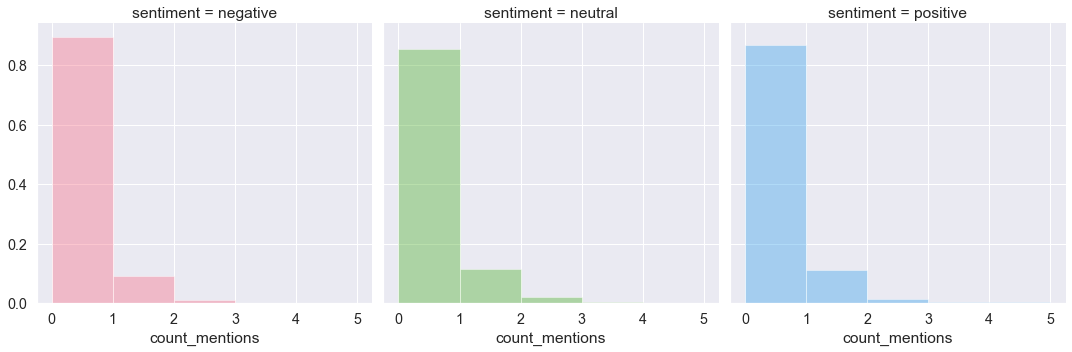

In [12]:
data_dist(data_eda,'count_mentions')

Descriptive stats for count_hashtags
------------------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
negative   9178.0  0.235236  0.616076  0.0  0.0  0.0  0.0  6.0
neutral    3099.0  0.214263  0.667354  0.0  0.0  0.0  0.0  6.0
positive   2363.0  0.297926  0.774886  0.0  0.0  0.0  0.0  8.0


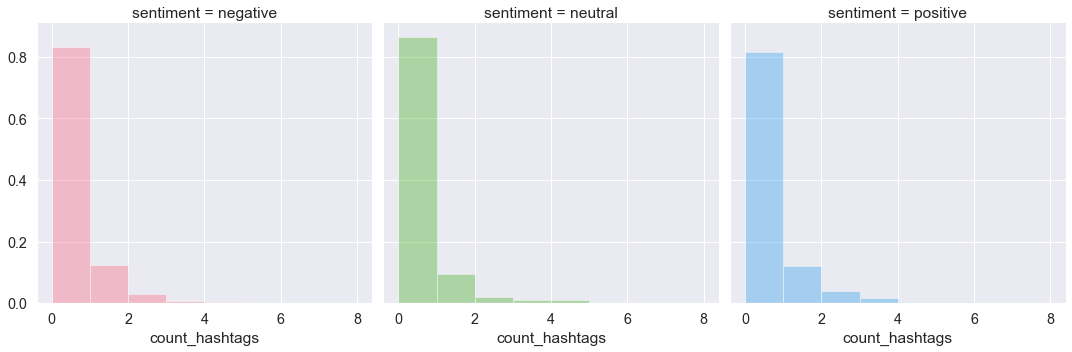

In [13]:
data_dist(data_eda,'count_hashtags')

Descriptive stats for count_capital_words
-----------------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
negative   9178.0  0.427762  1.016943  0.0  0.0  0.0  1.0  22.0
neutral    3099.0  0.454985  0.932601  0.0  0.0  0.0  1.0  11.0
positive   2363.0  0.454507  1.229379  0.0  0.0  0.0  0.0  20.0


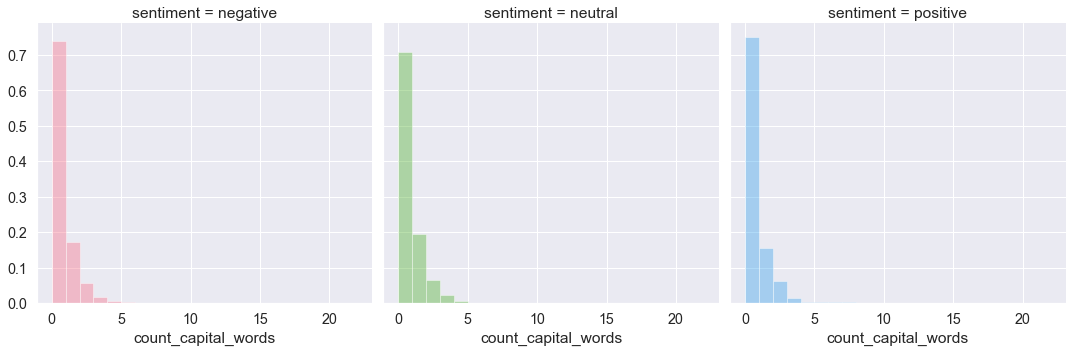

In [14]:
data_dist(data_eda,'count_capital_words')

Descriptive stats for count_excl_quest_marks
--------------------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
negative   9178.0  0.634779  1.143500  0.0  0.0  0.0  1.0  27.0
neutral    3099.0  0.660536  0.921531  0.0  0.0  0.0  1.0  12.0
positive   2363.0  0.889970  1.197548  0.0  0.0  1.0  1.0  13.0


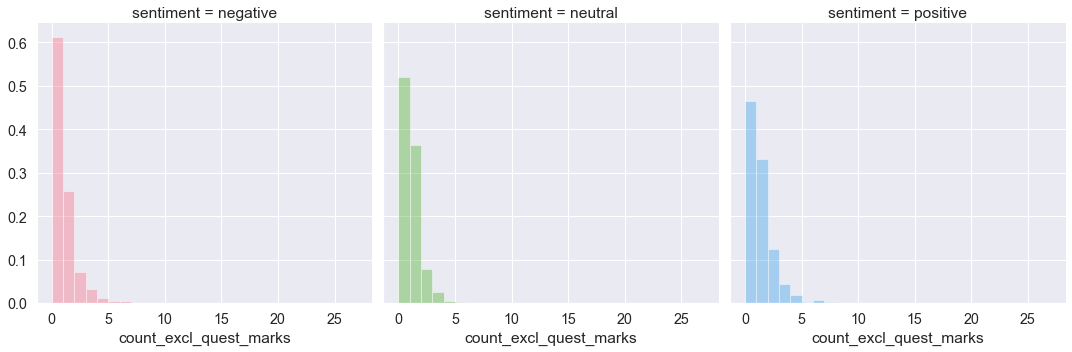

In [15]:
data_dist(data_eda,'count_excl_quest_marks')

Descriptive stats for count_urls
--------------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
negative   9178.0  0.049248  0.218403  0.0  0.0  0.0  0.0  2.0
neutral    3099.0  0.169409  0.400959  0.0  0.0  0.0  0.0  3.0
positive   2363.0  0.098603  0.303818  0.0  0.0  0.0  0.0  2.0


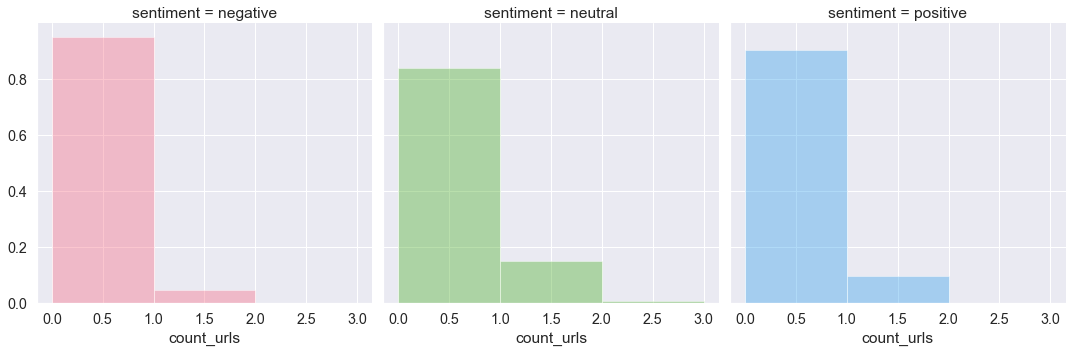

In [16]:
data_dist(data_eda,'count_urls')

Descriptive stats for count_emojis
----------------------------------
            count      mean     std  min  25%  50%  75%  max
sentiment                                                   
negative   9178.0  0.000000  0.0000  0.0  0.0  0.0  0.0  0.0
neutral    3099.0  0.000645  0.0254  0.0  0.0  0.0  0.0  1.0
positive   2363.0  0.000000  0.0000  0.0  0.0  0.0  0.0  0.0


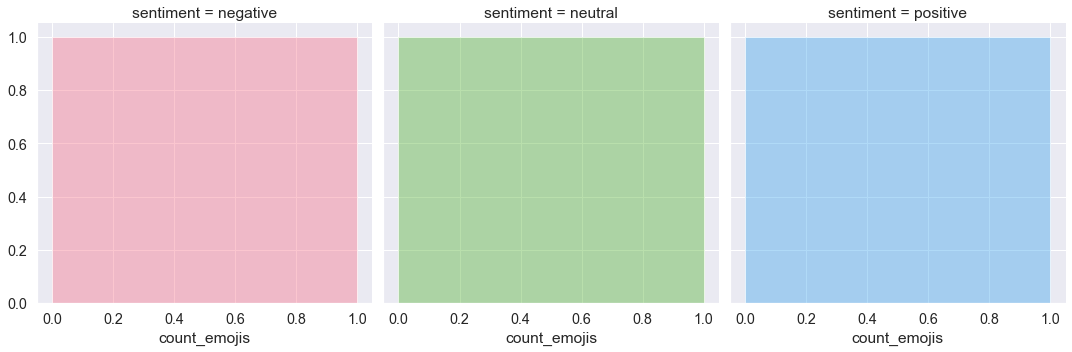

In [17]:
data_dist(data_eda,'count_emojis')

#  3. Cleaning the Text to prepare it for training and model evaluation
    Replacing mention with space.
    
    Replacing https links with space.
    
    Replacing emoji with space.
    
    Replacing punctuation with space.
    
    Replacing digits with space
    
    Lower case conversion of the text.
    
    Customised stop word removal .
    
    Stemming Process



In [18]:
# Below is the Estimator we have created to clean the text.Easy to pipeline it :) 

class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation #returns all variety of punctuation.not a function.
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space in this table.
        return input_text.translate(trantab)
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X


In [19]:
# data_eda
ct = CleanText()
sr_clean = ct.fit_transform(Data.text)
type(sr_clean)

pandas.core.series.Series

Substituting the rows with No text where no text left after cleaning

Remove the complete row,

Impute the missing value with some placeholder text like *[no_text]*

When applying Word2Vec: use the average of all vectors

In [20]:
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

25 records have no words left after text cleaning


Display the most used 20 words in the data

In [21]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
bow

<14640x8413 sparse matrix of type '<class 'numpy.int64'>'
	with 123936 stored elements in Compressed Sparse Row format>

In [23]:
# word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
cv.get_feature_names()

['aa',
 'aaaand',
 'aaadvantag',
 'aaalwaysl',
 'aadavantag',
 'aadelay',
 'aadv',
 'aadvantag',
 'aafail',
 'aal',
 'aaron',
 'aaso',
 'aateam',
 'ab',
 'aback',
 'abandon',
 'abassinet',
 'abbrev',
 'abc',
 'abcletjetbluestreamfe',
 'abcnew',
 'abduct',
 'abi',
 'abil',
 'abl',
 'aboard',
 'aboout',
 'abound',
 'abq',
 'abroad',
 'absolut',
 'absorb',
 'absoulut',
 'absurd',
 'absurdli',
 'abt',
 'abund',
 'abus',
 'abysm',
 'ac',
 'acarl',
 'acc',
 'acceler',
 'accept',
 'access',
 'accid',
 'accident',
 'accomid',
 'accommod',
 'accompani',
 'accomplish',
 'accord',
 'accordingli',
 'account',
 'accru',
 'acct',
 'accumul',
 'accur',
 'accuratetraveltim',
 'accus',
 'achiev',
 'aci',
 'ack',
 'acknowledg',
 'acosta',
 'acoust',
 'acpt',
 'acquir',
 'acquisit',
 'across',
 'act',
 'action',
 'activ',
 'actual',
 'actuali',
 'acu',
 'acw',
 'ad',
 'ada',
 'adam',
 'adapt',
 'add',
 'addit',
 'additon',
 'addr',
 'address',
 'addtl',
 'adjac',
 'adjust',
 'admin',
 'admir',
 'admit',


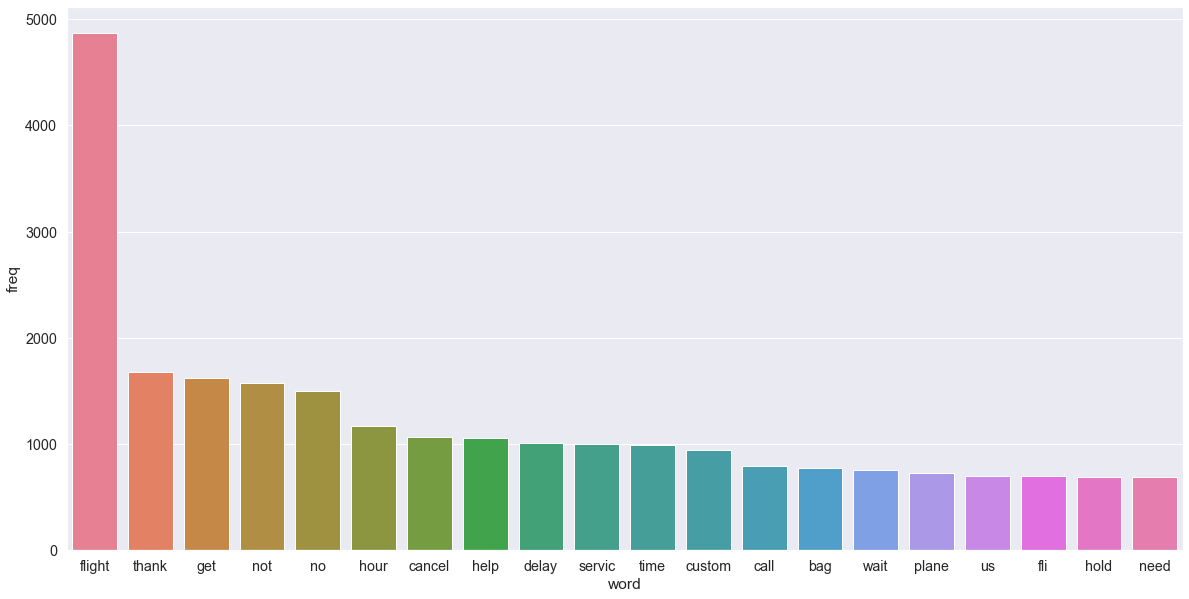

In [24]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="husl", ax=ax)
plt.show();

# Preparation for Model

In [25]:
df_model = data_eda
df_model['clean_text'] = sr_clean
df_model.columns.tolist()

['count_words',
 'count_mentions',
 'count_hashtags',
 'count_capital_words',
 'count_excl_quest_marks',
 'count_urls',
 'count_emojis',
 'sentiment',
 'clean_text']

In [26]:
#Split the data for training
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('sentiment', axis=1), df_model.sentiment, test_size=0.1, random_state=37)

Below is the Estimator to extract the requires column for model testing.

In [27]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols
    def transform(self, X, **transform_params):
        return X[self.cols]
    def fit(self, X, y=None, **fit_params):
        return self


# Hyperparameter tuning and cross-validation

Function 1 - grid_vect 

Input : Takes classifier with parameters , training data,testing data,and vectorizers parameters.

Output: It will generate the report for hyperparameter values,F1 Score - Precision,Recall and accuracy score.

In [28]:
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
    if is_w2v:
        w2vcols = []
#         print(SIZE)
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))]
                                , n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=-1)
    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
   
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()
    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search


Prameter grid setting for the vectorizers 

1. CountVectorizer

2. TF-IDF

In [29]:
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75), #ignore the term which has frequency higher than this.
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),# lies between these 2 bundary only unigram and uni and bigram.
    'features__pipe__vect__min_df': (1,2)
}

Parameter grid settings for Multinomial Naive Bayes

In [30]:
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75) # Something related with smoothing. default is 1. It adds pseudo count to probability.
}

Parameter grid settings for LogisticRegression

In [31]:
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0), #denotes the strength of the regularization.
    'clf__penalty': ('l1', 'l2')
}

Initialize the classifier - Logistic and Naive Byes

In [32]:
mnb = MultinomialNB()
logreg = LogisticRegression()

Vectorizer Name : CountVectorizer 

Classifiers tested : NaiveBayes and Logistic Regression

In [33]:
countvect = CountVectorizer()
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)


Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   15.7s finished


done in 16.709s

Best CV score: 0.774
Best parameters set:
	clf__alpha: 0.5
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.787


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.81      0.92      0.86       911
     neutral       0.67      0.47      0.56       320
    positive       0.79      0.71      0.74       233

    accuracy                           0.79      1464
   macro avg       0.76      0.70      0.72      1464
weighted avg       0.78      0.79      0.78      1464

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   49.4s finished


done in 51.820s

Best CV score: 0.793
Best parameters set:
	clf__C: 1.0
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.805


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.83      0.93      0.87       911
     neutral       0.71      0.52      0.60       320
    positive       0.80      0.73      0.76       233

    accuracy                           0.81      1464
   macro avg       0.78      0.72      0.75      1464
weighted avg       0.80      0.81      0.80      1464



Vectorizer Name : TF-IDF 

Classifiers tested : NaiveBayes and Logistic Regression

In [34]:
tfidfvect = TfidfVectorizer()
best_mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)
best_logreg_tfidf = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)


Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   13.5s finished


done in 14.435s

Best CV score: 0.747
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.755


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.74      0.97      0.84       911
     neutral       0.79      0.31      0.45       320
    positive       0.83      0.51      0.63       233

    accuracy                           0.75      1464
   macro avg       0.79      0.60      0.64      1464
weighted avg       0.77      0.75      0.72      1464

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   47.1s finished


done in 47.665s

Best CV score: 0.785
Best parameters set:
	clf__C: 1.0
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.798


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.80      0.95      0.87       911
     neutral       0.76      0.48      0.59       320
    positive       0.83      0.64      0.72       233

    accuracy                           0.80      1464
   macro avg       0.80      0.69      0.73      1464
weighted avg       0.80      0.80      0.78      1464



Vectorizer Name : Word2Vec 

Classifiers tested : NaiveBayes and Logistic Regression

In [35]:
SIZE = 50
X_train['clean_text_wordlist'] = X_train.clean_text.apply(lambda x : word_tokenize(x))
X_test['clean_text_wordlist'] = X_test.clean_text.apply(lambda x : word_tokenize(x))
model = gensim.models.Word2Vec(X_train.clean_text_wordlist, min_count=1, size=SIZE, window=5, workers=4)
model.most_similar('plane', topn=3)

[('gate', 0.9992610216140747),
 ('sit', 0.9990222454071045),
 ('tarmac', 0.9988731145858765)]

In [36]:
def compute_avg_w2v_vector(w2v_dict, tweet):
    list_of_word_vectors = [w2v_dict[w] for w in tweet if w in w2v_dict.vocab.keys()]
    
    if len(list_of_word_vectors) == 0:
        result = [0.0]*SIZE
    else:
        result = np.sum(list_of_word_vectors, axis=0) / len(list_of_word_vectors)
        
    return result
X_train_w2v = X_train['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))
X_test_w2v = X_test['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))

In [37]:
X_train_w2v = pd.DataFrame(X_train_w2v.values.tolist(), index= X_train.index)
X_test_w2v = pd.DataFrame(X_test_w2v.values.tolist(), index= X_test.index)
X_train_w2v = pd.concat([X_train_w2v, X_train.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)
X_test_w2v = pd.concat([X_test_w2v, X_test.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)

In [38]:
X_train_w2v

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis
1712,-0.281655,0.090625,-0.178953,-1.033109,-0.476059,0.124854,-0.337581,0.174969,0.888026,0.043095,...,0.333884,-0.286054,-0.222321,17,0,2,0,0,0,0
11975,-0.284024,0.434541,0.002871,-1.397331,-1.053907,-0.135777,-0.342677,-0.065598,0.982510,-0.456315,...,0.403769,-0.391366,0.109115,22,0,0,0,2,0,0
6919,-0.255043,0.137859,-0.072834,-0.941399,-0.531881,0.052404,-0.279330,0.066728,0.775148,-0.089340,...,0.298808,-0.253072,-0.102267,21,0,0,0,1,0,0
14030,-0.397701,0.290629,-0.101993,-1.476336,-0.898943,0.047153,-0.407714,0.040213,1.140622,-0.291124,...,0.450176,-0.415187,-0.148399,28,0,0,1,0,0,0
1907,-0.288125,0.193316,-0.079358,-1.102892,-0.655811,0.052335,-0.310584,0.033226,0.862509,-0.209755,...,0.331366,-0.316128,-0.128670,24,0,0,0,0,0,0
5796,-0.252548,0.149812,-0.088307,-0.916011,-0.527954,0.049694,-0.272813,0.050550,0.734124,-0.120206,...,0.279816,-0.250476,-0.121887,28,0,0,3,0,0,0
14066,-0.085783,0.017328,-0.027471,-0.319529,-0.148140,0.038563,-0.100070,0.043520,0.257551,-0.000378,...,0.105862,-0.078585,-0.059013,6,2,0,0,2,0,0
9484,-0.269458,0.141206,-0.094493,-0.953236,-0.518753,0.058416,-0.280324,0.088353,0.785795,-0.085862,...,0.300493,-0.255328,-0.125143,15,0,0,1,2,0,0
3318,-0.344234,0.123769,-0.121913,-1.193282,-0.593721,0.111301,-0.367301,0.126721,1.009154,-0.047274,...,0.390378,-0.331615,-0.198061,23,1,0,0,1,0,0
1724,-0.339398,0.178546,-0.120225,-1.232377,-0.686252,0.069965,-0.370214,0.083572,1.002533,-0.144142,...,0.373498,-0.353031,-0.180289,13,0,0,0,0,0,0


In [39]:
best_logreg_w2v = grid_vect(logreg, parameters_logreg, X_train_w2v, X_test_w2v, is_w2v=True)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0), 'clf__penalty': ('l1', 'l2')}
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   29.0s finished


done in 43.739s

Best CV score: 0.719
Best parameters set:
	clf__C: 1.0
	clf__penalty: 'l1'
Test score with best_estimator_: 0.708


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.71      0.95      0.81       911
     neutral       0.63      0.28      0.38       320
    positive       0.75      0.37      0.49       233

    accuracy                           0.71      1464
   macro avg       0.70      0.53      0.56      1464
weighted avg       0.70      0.71      0.67      1464



Final Choice for the parameters and Classifier

Classifier : Logistics Regression

C= 1.0

penalty=l2


Train with the final parameters

In [40]:
textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
,'count_mentions','count_urls','count_words']
features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
, ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text'))
, ('vect', CountVectorizer(max_df=0.5, min_df=1, ngram_range=(1,2)))]))]
, n_jobs=-1)
pipeline = Pipeline([
('features', features)
, ('clf', LogisticRegression(C=1, penalty='l2'))
])
best_model = pipeline.fit(df_model.drop('sentiment', axis=1), df_model.sentiment)

Test our model 

In [41]:
new_positive_tweets = pd.Series(["Thank you @VirginAmerica for you amazing customer support team on Tuesday 11/28 at @EWRairport and returning my lost bag in less than 24h! #efficiencyiskey #virginamerica"
,"Love flying with you guys ask these years. Sad that this will be the last trip ? @VirginAmerica #LuxuryTravel"
,"Wow @VirginAmerica main cabin select is the way to fly!! This plane is nice and clean & I have tons of legroom! Wahoo! NYC bound! ✈️"])
df_counts_pos = tc.transform(new_positive_tweets)
df_clean_pos = ct.transform(new_positive_tweets)
df_model_pos = df_counts_pos
df_model_pos['clean_text'] = df_clean_pos
best_model.predict(df_model_pos).tolist()

['positive', 'positive', 'positive']